In [1]:
# !pip install matplotlib
# !pip install pandas
# !pip install numpy
# !pip install openpyxl

In [2]:
# 자기소개서 데이터 RAW와 label 분리 (다중 분류 임)
# 점수 구현은 따로 구현(GPT로 post-processing)

In [3]:
import os
import re
import json
from tqdm import tqdm

import pandas as pd
import numpy as np

from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from transformers import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import accuracy_score


/home/najo/.conda/envs/test_20240708/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0, 1, 2"  # Set the GPUs 2 and 3 to use

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

torch.cuda.manual_seed_all(42)

Device: cuda
Current cuda device: 0
Count of using GPUs: 3


In [5]:
# 파일 불러오고 df에 저장(raw_text 특수문자 제거)

file_path = "/home/najo/NAS/ONLAB/ONLAB_Competency/2024-10-15"
file_name = [f for f in os.listdir(file_path) if f.endswith('.json')]

df = pd.DataFrame(columns=['raw_text', 'class'])

count = 0
for i in tqdm(file_name):
    with open(os.path.join(file_path, i), 'r', encoding='utf-8') as file:  # Use 'r' mode for reading text files
        data = json.load(file)
        
        for idx in data['anno_text_data']['data']:
            n_class = list(filter(None, idx['class'].split(",")))
            for n in n_class:
                # df.loc[count, 'count'] = count
                df.loc[count, 'raw_text'] = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", idx['raw'])
                df.loc[count, 'class'] = n
                count += 1

print(df)


  4%|▍         | 227/6011 [00:00<00:05, 1129.92it/s]

100%|██████████| 6011/6011 [00:10<00:00, 562.09it/s]

                                                raw_text class
0      아버지에게서 배운 성실성과 소통 능력\n\n평소 꾸준함과 성실함을 강조하시던 부모님...    13
1      저는 루틴이 가진 강력한 힘을 알고 이용할 줄 압니다 루틴이란 규칙적으로하는 일의 ...    16
2      저는 루틴이 가진 강력한 힘을 알고 이용할 줄 압니다 루틴이란 규칙적으로하는 일의 ...    13
3      저는 루틴이 가진 강력한 힘을 알고 이용할 줄 압니다 루틴이란 규칙적으로하는 일의 ...    17
4      코로나 사태로 세계 경제 시장은 더욱 악화되고 있지만 국내 생산거점을 기반으로 내실...    14
...                                                  ...   ...
16655  저는 기업 니즈를 기반으로 한 영업을 통해 6개 기업을 설득했습니다 대학생 동아리 ...     6
16656  저는 기업 니즈를 기반으로 한 영업을 통해 6개 기업을 설득했습니다 대학생 동아리 ...    13
16657  저는 기업 니즈를 기반으로 한 영업을 통해 6개 기업을 설득했습니다 대학생 동아리 ...    15
16658  영업은 고객과 같이 성장하는 직무입니다 고객의 성공이 관계 유지를 가져오기 때문입니...    14
16659  세계적으로 선진국들은 점차 환경규제를 강화하고 있는 추세이며 유럽연합에서는 이미 상...    14

[16660 rows x 2 columns]


In [6]:
df['class'].value_counts()

class
6     2024
11    1867
14    1568
17    1398
12    1008
5     1000
15     998
16     990
7      934
13     784
10     761
2      652
3      579
4      494
1      370
20     345
18     218
8      206
9      201
19     134
21     129
Name: count, dtype: int64

In [7]:
df['raw_text'] = df['raw_text'].astype(str)
df['class'] = df['class'].astype(float)
print(df.dtypes)

raw_text     object
class       float64
dtype: object


In [8]:
# TinyBERT 모델과 토크나이저 로드
model_name = "monologg/koelectra-small-v3-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=22)  # 레이블 3개로 설정

/home/najo/.conda/envs/test_20240708/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index, 0]
        label = self.data.iloc[index, 1]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

max_len = 128
train_dataset = CustomDataset(df, tokenizer, max_len)


In [10]:
next(iter(train_dataset))

{'input_ids': tensor([    2,  6734,  4073,  4325,  4129, 11776, 10944,  4028,  4047,  7891,
          6633,  7800,  7939,  4418,  4047, 10944,  4418,  4292,  6575, 29365,
          4820,  6983,  4660,  4112,  3288,  4070,  4153,  4286,  4303,  6484,
          4007,  2411,  4031,  4110,  6908,  5240,  4576,  6216,  6734,  5253,
         28893,  3278,  4073,  4325,  7118, 10981,  4292,  7200,  4279,  5240,
          4219,  3278,  4034,  7561,  7197,    25,  4075,  4556,  6406,  8281,
         10547,  3280,  6223,  7465,  7118,  6506,  4292,  3755,  4737,  4576,
          6216,  3240,  4110,  6260,  3278,  4034, 10944,  4028,  4047,  7891,
          4361,  4292, 16158,  2967,  3249,  4480,  4576,  6216,     3,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [11]:
# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# 모델 학습 함수
def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # 모델의 출력에서 loss 추출
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss.mean()  # loss 값을 여러 GPU에서 평균
        
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    return total_loss / len(data_loader)

# 모델 저장 함수 (DataParallel 지원)
def save_model(model, optimizer, epoch, loss, file_name):
    save_path = f"/home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model/{file_name}.pth"
    
    # DataParallel로 감싸져 있는 모델을 저장할 때는 model.module로 접근
    if isinstance(model, torch.nn.DataParallel):
        model_to_save = model.module
    else:
        model_to_save = model
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_to_save.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, save_path)
    
    print(f"Model saved as {save_path}")

# GPU 설정
model = model.to(device)
model = nn.DataParallel(model)

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=2e-5)

# 학습 루프
epochs = 100
best_loss = float('inf')  # 최소 손실을 추적하기 위한 변수
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss}")

    # 손실이 이전 손실보다 작으면 모델 저장
    if train_loss < best_loss:
        best_loss = train_loss
        # 손실 값을 파일명에 포함, 소수점 5자리까지 사용
        file_name = f"model_loss_{best_loss:.5f}"
        save_model(model, optimizer, epoch, best_loss, file_name)


/home/najo/.conda/envs/test_20240708/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/najo/.conda/envs/test_20240708/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch 1/100, Loss: 3.0088208595304997
Model saved as /home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model/model_loss_3.00882.pth
Epoch 2/100, Loss: 2.8657206469819747
Model saved as /home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model/model_loss_2.86572.pth
Epoch 3/100, Loss: 2.7533478463879066
Model saved as /home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model/model_loss_2.75335.pth
Epoch 4/100, Loss: 2.657776341183495
Model saved as /home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model/model_loss_2.65778.pth
Epoch 5/100, Loss: 2.5866872117719577
Model saved as /home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model/model_loss_2.58669.pth
Epoch 6/100, Loss: 2.529079186097356
Model saved as /home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model/model_loss_2.52908.pth
Epoch 7/100, Loss: 2.469521251343589
Model saved as /home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model/model_loss_2.46952.pth
Epoch 8/100, Loss: 2.4346929670290183
Model saved as /home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model/model_loss_2.43469

In [14]:
import os
import torch
import re
from sklearn.metrics import accuracy_score

# 평가 함수
def eval_model(model, data_loader, device):
    model = model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())  # GPU 텐서를 CPU로 이동 후 NumPy로 변환
            true_labels.extend(labels.cpu().numpy())  # 레이블도 동일하게 처리
    
    return accuracy_score(true_labels, predictions)

# 저장된 모델 불러오기 함수
def load_best_model(model, optimizer, device, file_path):
    checkpoint = torch.load(file_path)
    
    # DataParallel로 감싸진 경우에도 model.module로 저장되었는지 확인
    if isinstance(model, torch.nn.DataParallel):
        model.module.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint['model_state_dict'])
    
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    model = model.to(device)  # 모델을 다시 GPU로 보냄
    print(f"Loaded model from {file_path}, Epoch: {epoch}, Loss: {loss:.5f}")
    
    return model, optimizer

# 저장된 모델 파일 중에서 가장 작은 손실 값을 가진 모델 파일을 찾는 함수
def find_best_model_file(model_dir):
    best_loss = float('inf')
    best_model_file = None
    
    # 모델 파일명을 탐색하고, 손실값이 포함된 파일명을 파싱하여 최소 손실값을 찾음
    for file_name in os.listdir(model_dir):
        if file_name.endswith(".pth"):
            # 파일명에서 손실 값을 추출 (예: model_loss_0.12345.pth에서 0.12345 추출)
            match = re.search(r'model_loss_([\d.]+)\.pth', file_name)
            if match:
                loss = float(match.group(1))
                if loss < best_loss:
                    best_loss = loss
                    best_model_file = file_name
    
    if best_model_file:
        print(f"Best model found: {best_model_file} with loss {best_loss:.5f}")
    else:
        print("No valid model files found.")
    
    return best_model_file

# 저장된 최적의 모델 불러오기 및 평가
def evaluate_best_model(model, optimizer, data_loader, device, model_dir):
    best_model_file = find_best_model_file(model_dir)
    
    if best_model_file:
        file_path = os.path.join(model_dir, best_model_file)
        model, optimizer = load_best_model(model, optimizer, device, file_path)
        
        # 모델 평가
        val_accuracy = eval_model(model, data_loader, device)
        print(f'Validation Accuracy: {val_accuracy:.4f}')
    else:
        print("No model file to evaluate.")

# 검증 데이터 로더로 변경하는 것이 일반적
# 여기서는 train_loader 대신 val_loader 또는 test_loader를 사용하는 것이 좋습니다
best_model_path = "/home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model"

# 학습 후 검증 데이터 평가
evaluate_best_model(model, optimizer, train_loader, device, best_model_path)  # 평가할 때는 val_loader 사용을 권장


Best model found: model_loss_1.34424.pth with loss 1.34424


/tmp/ipykernel_2725147/2727550360.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Loaded model from /home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model/model_loss_1.34424.pth, Epoch: 98, Loss: 1.34424
Validation Accuracy: 0.5061


In [18]:
# 새로운 텍스트에 대해 예측 함수 (저장된 모델을 불러와 예측)
def predict(text, model, tokenizer, max_len, device, model_dir):
    # 가장 낮은 loss 값을 가진 모델 파일 찾기
    best_model_file = find_best_model_file(model_dir)
    
    if best_model_file is None:
        raise ValueError("No valid model file found.")
    
    model_path = os.path.join(model_dir, best_model_file)
    
    # 모델을 저장된 상태로 불러오기
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)  # 옵티마이저 임시 생성
    model, optimizer = load_best_model(model, optimizer, device, model_path)

    # 입력 텍스트를 토크나이저로 인코딩
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # 예측
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()  # 클래스 예측
    
    return pred

# 예측 사용 예시
sample_text = "기재한 역량 및 기술 중 한 가지 이상을 선택하고 그러한 역량 및 기술을 적극적으로 활용했던 경험 또는 이를 습득하기까지의 과정을 기술하여 주십시오.\n\n\"업무 추진력의 바탕 : 세밀한 기획\"\n\n인문학 교실을 기획하고 운영하는 프로그램 당시, 일정이 바뀌어 인턴십이 겹치고 하차 인원이 생겨 인력, 시간이 부족했고 이를 극복하기 위해 다음과 같이 행동했습니다.\n\n첫째, 진행된 과제 상황을 파악하고 앞으로 해야 할 일과 사용 가능한 시간을 리스트로 만들었습니다. 그리고 우선순위에 따라 시간을 배분한 후 추가적으로 필요한 시간을 확인했습니다.\n\n둘째, 불필요한 업무 프로세스를 개선해 부족한 시간을 확보했습니다. 반복되는 자료와 문서는 형상관리를 이용해 재사용할 수 있도록 했습니다.\n\n셋째, 또 다른 일정 변동에 대비해 강의자를 2인 1조로 구성했고, 수업을 하는 동안 강의록을 작성해 최종 보고서 작성 시간도 줄일 수 있었습니다."
re_sample_text = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", sample_text)

# 저장된 모델 경로를 사용해 예측
predicted_class = predict(re_sample_text, model, tokenizer, max_len, device, best_model_path)
print(f"Predicted Class: {predicted_class}")


Best model found: model_loss_1.34424.pth with loss 1.34424
Loaded model from /home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model/model_loss_1.34424.pth, Epoch: 98, Loss: 1.34424


/tmp/ipykernel_2725147/2727550360.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Predicted Class: 18


In [12]:
index_count = []
classes = []

# List of classes to exclude
exclude_classes = {' ', ''}  # Use a set for faster lookups

# Assuming file_name is a list of filenames and file_path is the directory where these files are stored
for i in file_name:
    with open(os.path.join(file_path, i), 'r', encoding='utf-8') as file:  # Use 'r' mode for reading text files
        data = json.load(file)
        
        # Step 1: Extract class mentions
        for entry in data['anno_text_data']['data']:
            # Filter out classes that should be excluded
            classes.extend([cls for cls in entry['class'].split(',') if cls not in exclude_classes])

# Step 2: Count occurrences of each class
class_counts = Counter(classes)

# Step 3: Calculate the total number of class mentions
total_count = sum(class_counts.values())

# Step 4: Display the results sorted by count in descending order
print("Class mention counts (sorted by count):")
for class_id, count in sorted(class_counts.items(), key=lambda item: item[1], reverse=True):
    print(f"Class {class_id}: {count}")

# Print the total sum of all counts
print(f"Total number of class mentions: {total_count}")


Class mention counts (sorted by count):
Class 6: 2024
Class 11: 1867
Class 14: 1568
Class 17: 1398
Class 12: 1008
Class 5: 1000
Class 15: 998
Class 16: 990
Class 7: 934
Class 13: 784
Class 10: 761
Class 2: 652
Class 3: 579
Class 4: 494
Class 1: 370
Class 20: 345
Class 18: 218
Class 8: 206
Class 9: 201
Class 19: 134
Class 21: 129
Total number of class mentions: 16660


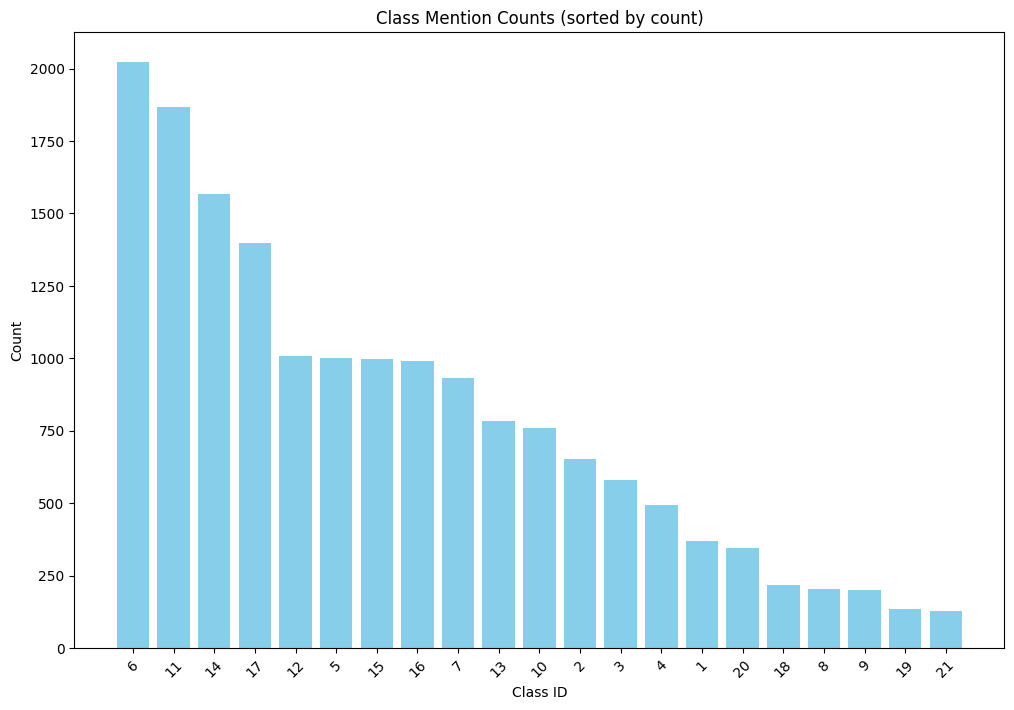

In [13]:
# Sort by count in descending order
sorted_class_counts = sorted(class_counts.items(), key=lambda item: item[1], reverse=True)

# Extract class IDs and counts for plotting
class_ids, counts = zip(*sorted_class_counts)

# Plotting the results
plt.figure(figsize=(12, 8))
plt.bar(class_ids, counts, color='skyblue')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.title('Class Mention Counts (sorted by count)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [14]:
index  = pd.read_excel("/home/najo/NAS/ONLAB/ONLAB_Competency/keyword-index.xlsx")

print(index)

                Name  Index
0            창의력을 가진      1
1         유연한 사고를 가진      2
2   데이터 기반의 의사결정을 하는      3
3       다양한 의견을 수렴하는      4
4        문제해결능력이 뛰어난      5
5    탄탄한 의사소통 능력을 가진      6
6       선한 영향력을 행사하는      7
7          다양성을 존중하는      8
8          신뢰를 주는 리더      9
9            적응력이 높은     10
10     지속적인 성장을 추구하는     11
11          비전을 제시하는     12
12     고도의 자기주도성을 가진     13
13      비즈니스 마인드를 갖춘     14
14       고도의 책임감을 가진     15
15              적극적인     16
16   목표를 달성하는 능력을 갖춘     17
17    자원을 효율적으로 활용하는     18
18     신속한 의사결정을 내리는     19
19       긍정적인 태도를 갖춘     20
20  위기 상황에서도 안정감을 주는     21
